In [1]:
import requests
from requests_ntlm import HttpNtlmAuth
import json
import csv
import sys
import netrc
from datetime import datetime

## First go get all the booking records and dump it to CSV from json

In [2]:
# get user / password
host = 'torvmpiis8.na.sas.com'
parking_url = 'http://torvmpiis8.na.sas.com/ParkingApp/BookingCalendar/GetBooking'
# Read from the .netrc file in your home directory
secrets = netrc.netrc()
dusername, account, password = secrets.authenticators(host)
#print ("\"" + dusername + "\" \"" + password + "\"")

try:
        bookings = requests.get(parking_url,auth=HttpNtlmAuth(dusername,password))
        bookings.raise_for_status()
except requests.exceptions.HTTPError as err:
        print ("failed to make server connection[parking URL]: " + str(err))
#         sys.exit(1)

# parse to json and write to csv
data = json.loads(bookings.text)
spots = data["BList"]

with open('spots.csv', 'w') as csvfile:
        fieldnames = ['pspot','name','date','bookOrPost','period','spot']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n')
        writer.writeheader()
        for spot in spots:
                spot['pspot'] = spot['spot'].split(' ')[0]
                spot['name'] = spot['spot'].split(' ')[1]
                spot['period'] = (spot['spot'].split('(')[1]).split(' ')[0]
                writer.writerow(spot)

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Start our exploration

In [4]:
## read in the file we just wrote
df = pd.read_csv("spots.csv")
df.tail(3)

,pspot,name,date,bookOrPost,period,spot
1854,62,M.Faiyaz,2017-05-11,B,DAY,62 M.Faiyaz Nakhuda (DAY )
1855,62,M.Faiyaz,2017-05-12,B,DAY,62 M.Faiyaz Nakhuda (DAY )
1856,62,C.Carito,2017-05-25,B,DAY,62 C.Carito (DAY )


In [5]:
# do this later

## add some features

df['datetime'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['t_weekday'] = df['datetime'].dt.weekday
df['t_day'] = df['datetime'].dt.day
df['t_month'] = df['datetime'].dt.month
df['t_year'] = df['datetime'].dt.year
df['t_weekofyear'] = df['datetime'].dt.weekofyear
df['t_weekday_name'] = df['datetime'].dt.weekday_name
df.drop(['period','spot','date'],axis=1,inplace=True)  ## this is redundant since we've already extracted pspot, name.
# df.head(3)

In [6]:
## write it out in case we want to reuse it later.
df.to_csv("spots_augmented.csv")

### Build a structure that we can plot later comparing first 6 months to last 6 months

In [7]:
compare = pd.DataFrame.from_items([('beneficiaries', [0, 0,0,0]), ('spots_booked', [0, 0,0,0])], 
                        orient='index', columns=['First6', 'Last6','First3', 'Last3'])

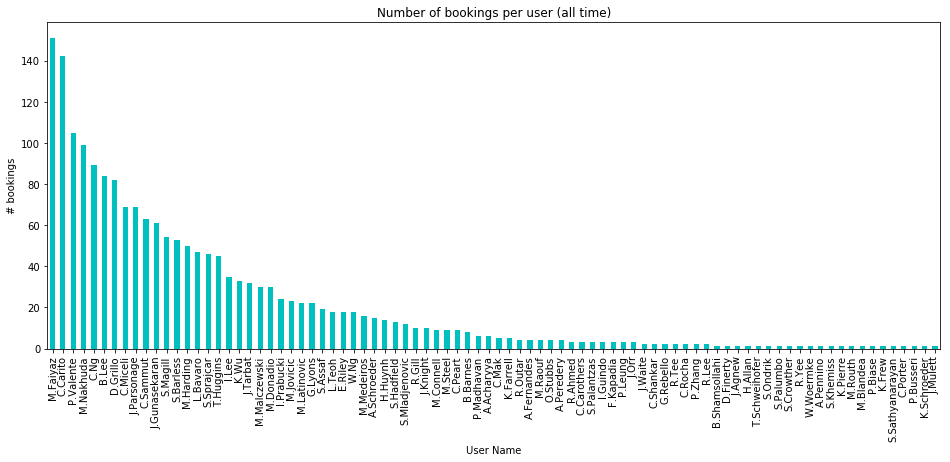

In [8]:
## plot all time bookings per user
tbl_forplot  = pd.Series(df['name'].value_counts())
freq= tbl_forplot.plot(kind  = 'bar', title = 'Number of bookings per user (all time)', color = 'c', figsize = (16, 6))
freq.set_ylabel('# bookings')
freq.set_xlabel('User Name');

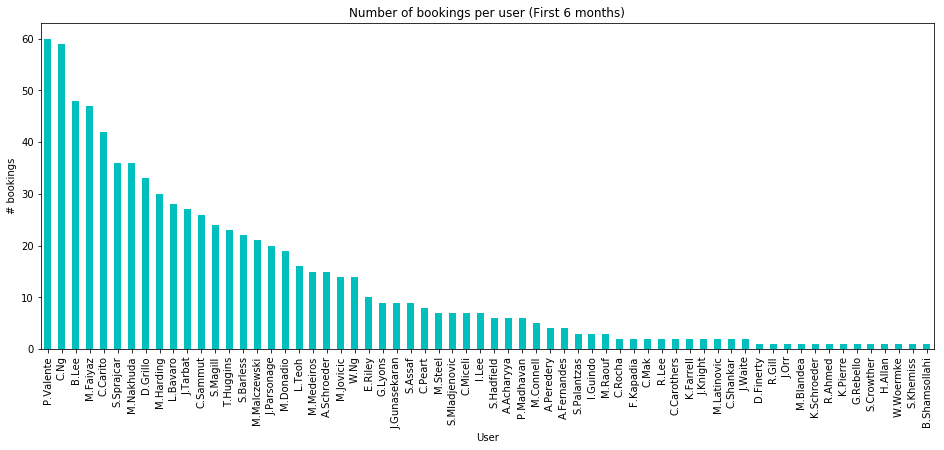

In [9]:
## compare first 6 months. Nice distribution of users booking parking spots
tbl_forplot  = pd.Series(df[(df['datetime'] > '2015-8-24') & (df['datetime'] <= '2016-2-24')]['name'].value_counts())
freq= tbl_forplot.plot(kind  = 'bar', title = 'Number of bookings per user (First 6 months)', color = 'c', figsize = (16, 6))
freq.set_ylabel('# bookings')
freq.set_xlabel('User');
## compare for later
compare['First6']['beneficiaries'] = tbl_forplot.count()
compare['First6']['spots_booked'] = tbl_forplot.sum()

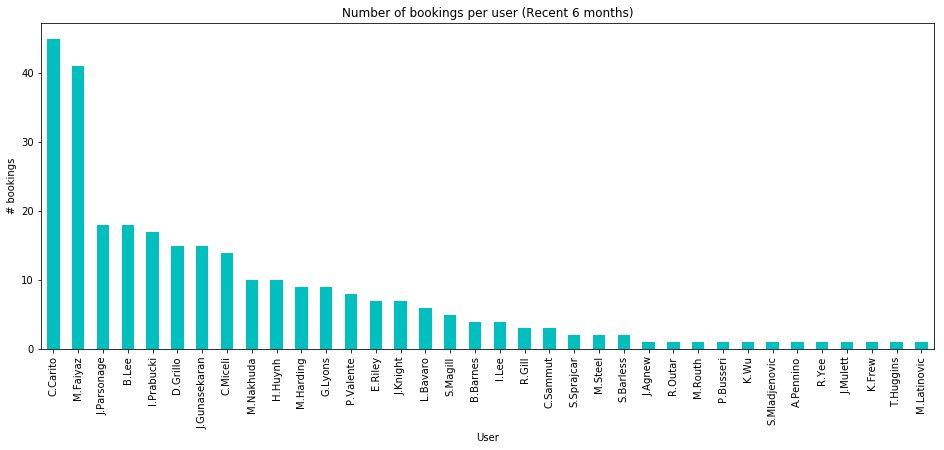

In [21]:
## most recent 6 months
tbl_forplot  = pd.Series(df[(df['datetime'] > '2016-10-10') & (df['datetime'] <= '2017-4-10')]['name'].value_counts())
freq = tbl_forplot.plot(kind  = 'bar', title = 'Number of bookings per user (Recent 6 months)', color = 'c', figsize = (16, 6))
freq.set_ylabel('# bookings')
freq.set_xlabel('User');
## compare for later
## compare for later
compare['Last6']['beneficiaries'] = tbl_forplot.count()
compare['Last6']['spots_booked'] = tbl_forplot.sum()

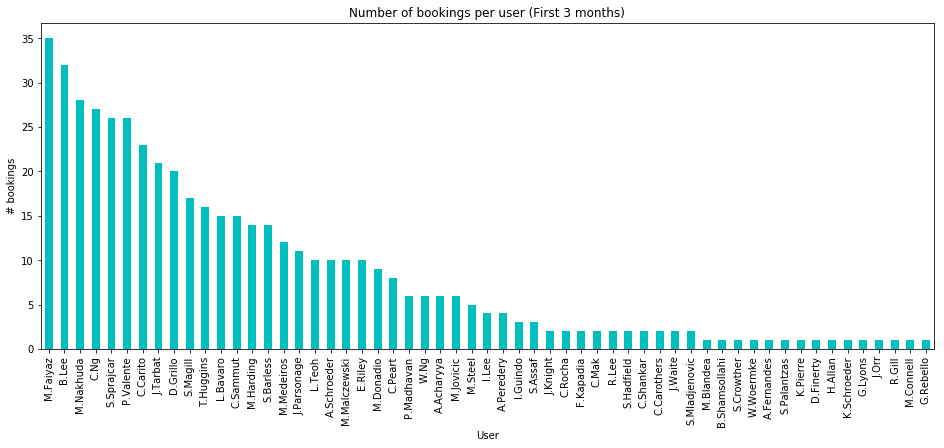

In [10]:
## compare first 3 months. Nice distribution of users booking parking spots
tbl_forplot  = pd.Series(df[(df['datetime'] > '2015-8-24') & (df['datetime'] <= '2015-11-24')]['name'].value_counts())
freq= tbl_forplot.plot(kind  = 'bar', title = 'Number of bookings per user (First 3 months)', color = 'c', figsize = (16, 6))
freq.set_ylabel('# bookings')
freq.set_xlabel('User');
## compare for later
compare['First3']['beneficiaries'] = tbl_forplot.count()
compare['First3']['spots_booked'] = tbl_forplot.sum()

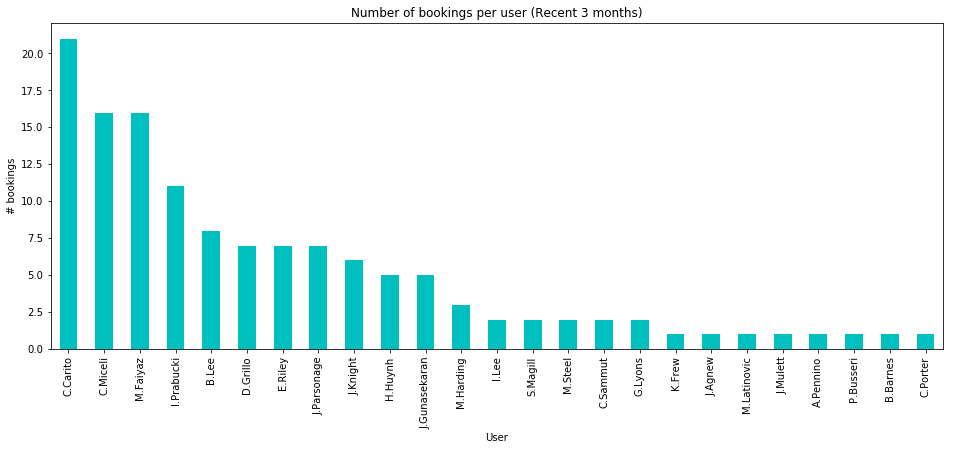

In [11]:
## most recent 3 months
tbl_forplot  = pd.Series(df[(df['datetime'] > '2017-2-5') & (df['datetime'] <= '2017-5-4')]['name'].value_counts())
freq = tbl_forplot.plot(kind  = 'bar', title = 'Number of bookings per user (Recent 3 months)', color = 'c', figsize = (16, 6))
freq.set_ylabel('# bookings')
freq.set_xlabel('User');
## compare for later
## compare for later
compare['Last3']['beneficiaries'] = tbl_forplot.count()
compare['Last3']['spots_booked'] = tbl_forplot.sum()

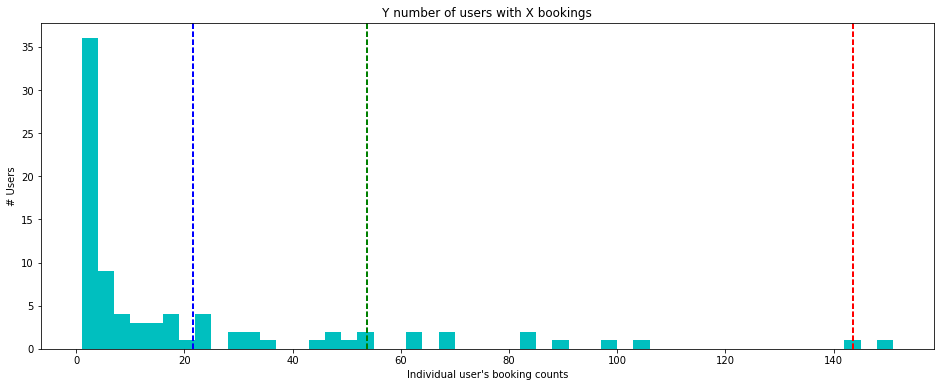

In [12]:
## histogram
tbl_forplot  = pd.Series(df['name'].value_counts())
freq= tbl_forplot.plot.hist(title = 'Y number of users with X bookings', bins=50, color = 'c', figsize = (16, 6))
freq.set_ylabel('# Users')
freq.set_xlabel('Individual user\'s booking counts');
freq.axvline(tbl_forplot.mean(), color='b', linestyle='dashed', linewidth=2)
# mean plus 1 std_Dev
freq.axvline(tbl_forplot.mean()+tbl_forplot.std(), color='g', linestyle='dashed', linewidth=2) 
# mean plus 3.8 std_Dev
freq.axvline(tbl_forplot.mean()+(tbl_forplot.std()*3.8), color='r', linestyle='dashed', linewidth=2)   

## Users with very high booking counts

In [ ]:
users = df[(df['name'] == 'C.Carito')].sort_values(by='datetime')
users.head(3)

In [ ]:
users = df[(df['name'] == 'M.Faiyaz')].sort_values(by='datetime')
users.head(3)

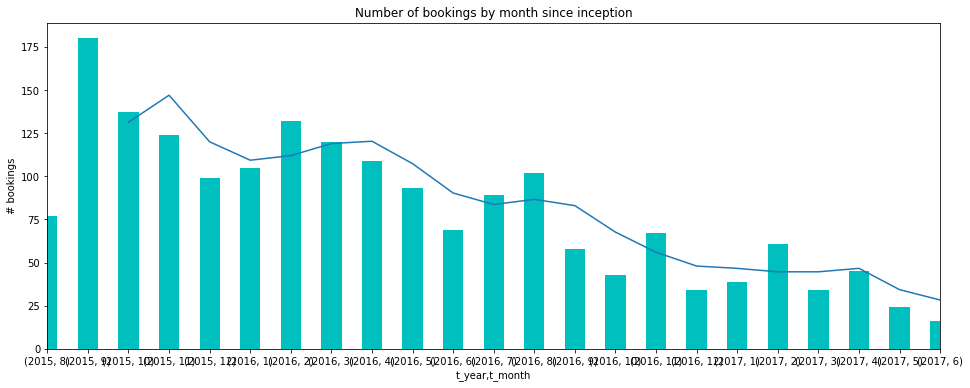

In [14]:
## how does the total number of bookings look over time?
tbl_forplot  = pd.Series(df.groupby(['t_year','t_month']).size())
rolling_avg = tbl_forplot.rolling(win_type='boxcar',center=False,window=3,axis=0).mean()
plt.figure()
tbl_forplot_plot = tbl_forplot.plot(kind  = 'bar', 
                                    title = 'Number of bookings by month since inception', 
                                    color = 'c', figsize = (16, 6))
tbl_forplot_plot.set_ylabel('# bookings')
tbl_forplot_plot.set_xlabel('Month');
rolling_avg_plot = rolling_avg.plot()

## Try a Forcast on the above data

In [ ]:
# todo

## Join spot IDs with names

In [17]:
## Create a lookup table of SpotIds to Names
spot_range = pd.DataFrame(pd.Series(np.arange(1,64)), columns=['SpotId'])
spot_names = pd.read_csv("spot_names.csv", " ")
# spot_names
# spot_range
spot_names['SpotId'] =  spot_names['SpotId'].astype(int)
spot_name_lookup = pd.merge(spot_range,spot_names, how='left', on='SpotId')
spot_name_lookup.head(6)

,SpotId,Name
0,1,Ferrell
1,2,Thompson
2,3,NaN
3,4,Lisi
4,5,NaN
5,6,Reed


### Which Users have posted the most spots over time?

In [18]:
## last 6 months
top10s = df[(df['datetime'] > '2016-10-10') & (df['datetime'] <= '2017-4-10')]['pspot'].value_counts().head(10)
top10d = pd.DataFrame(top10s).reset_index()
top10d.columns = ['SpotId','Counts']
top10_table = pd.merge(top10d,spot_name_lookup, how='left', on='SpotId')
top10_table.head()

,SpotId,Counts,Name
0,24,47,Antram
1,49,35,Holder
2,6,27,Reed
3,39,20,Derry
4,25,20,Tulley


In [19]:
## all time - where did spot owner #5 go?
top10s = df['pspot'].value_counts().head(10)
top10d = pd.DataFrame(top10s).reset_index()
top10d.columns = ['SpotId','Counts']
top10_table = pd.merge(top10d,spot_name_lookup, how='left', on='SpotId')
top10_table.head()

,SpotId,Counts,Name
0,25,196,Tulley
1,24,181,Antram
2,5,134,NaN
3,8,116,Welsh
4,49,97,Holder


### Let's compare the First 6 months of operation to the last 6 months

In [22]:
type(compare)
compare_t = compare.rename(index=str,columns={'First6':'First 6 Months','Last6':'Last 6 Months',
                                              'First3':'First 3 Months','Last3':'Last 3 Months'}).transpose()
compare_t

,beneficiaries,spots_booked
First 6 Months,64,821
Last 6 Months,36,286
First 3 Months,57,487
Last 3 Months,25,130


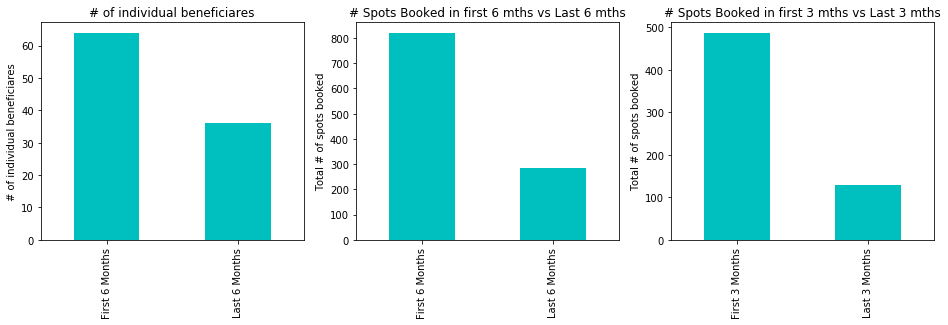

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize = (16, 4))

plot_benefactors = compare_t['beneficiaries'][0:2].plot(ax=axes[0], kind='bar', color='c' )
plot_benefactors.set_title('# of individual beneficiares')
plot_benefactors.set_ylabel('# of individual beneficiares')

plot_spots = compare_t['spots_booked'][0:2].plot(ax=axes[1], kind='bar', color='c')
plot_spots.set_title('# Spots Booked in first 6 mths vs Last 6 mths')
plot_spots.set_ylabel('Total # of spots booked')

# compare_t['beneficiaries']['change'] = compare_t['beneficiaries'].pct_change()
# compare_t['spots_booked']['change'] = compare_t['spots_booked'].pct_change()

plot_spots = compare_t['spots_booked'][2:5].plot(ax=axes[2], kind='bar', color='c')
plot_spots.set_title('# Spots Booked in first 3 mths vs Last 3 mths')
plot_spots.set_ylabel('Total # of spots booked')


In [24]:
# Only the "Last X Months" row is valid for pct_change()
compare_t['pct_change_ben'] = compare_t['beneficiaries'].pct_change()
compare_t['pct_change_spot_booked'] = compare_t['spots_booked'].pct_change()
compare_t

,beneficiaries,spots_booked,pct_change_ben,pct_change_spot_booked
First 6 Months,64,821,NaN,NaN
Last 6 Months,36,286,-0.437500,-0.651644
First 3 Months,57,487,0.583333,0.702797
Last 3 Months,25,130,-0.561404,-0.733060


### Let's expand the data set to include spots that weren't booked/posted. 

In [31]:
start_dt = datetime(2015, 8, 24)
end_dt = pd.to_datetime(datetime(2017,7,2))
rng_df = pd.DataFrame(pd.bdate_range(start_dt, end_dt), columns=['Date'])  # date range set
spot_range = pd.DataFrame(pd.Series(np.arange(1,63)), columns=['SpotId']) # 62 items in the spot range set
date_and_spot = pd.merge(rng_df.assign(key=0), spot_range.assign(key=0), on='key').drop('key', axis=1) # cartesian product
date_and_spot.tail(3)

,Date,SpotId
30067,2017-06-30,60
30068,2017-06-30,61
30069,2017-06-30,62


### Join it to the above detailed table

In [32]:
df = df.rename(index=str, columns={'pspot': 'SpotId', 'datetime':'Date'})
df.head(2)

,SpotId,name,bookOrPost,Date,t_weekday,t_day,t_month,t_year,t_weekofyear,t_weekday_name
0,1,C.Carito,B,2015-08-24,0,24,8,2015,35,Monday
1,1,W.Ng,B,2015-08-25,1,25,8,2015,35,Tuesday


In [33]:
abt = pd.merge(date_and_spot, df, how='outer',on=['Date','SpotId'])
abt = abt.rename(index=str,columns={'bookOrPost': 'Booked'})
abt['Booked'] = abt['Booked'].replace(to_replace='B', value=int(1))
abt['Booked'] = abt['Booked'].replace(to_replace=np.NaN, value=int(0))
abt.tail(3)

,Date,SpotId,name,Booked,t_weekday,t_day,t_month,t_year,t_weekofyear,t_weekday_name
30101,2017-06-30,60,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
30102,2017-06-30,61,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
30103,2017-06-30,62,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# add features for these columns
# abt['t_weekday'] = abt['Date'].dt.weekday
# abt['t_day'] = abt['Date'].dt.day
# abt['t_month'] = abt['Date'].dt.month
# abt['t_year'] = abt['Date'].dt.year
# abt['t_weekofyear'] = abt['Date'].dt.weekofyear
# abt['t_weekday_name'] = abt['Date'].dt.weekday_name

#abt.tail(15)

## Here are the SpotId's that have *never* posted their spots
#### We don't know who these people are because they don't have any record of their name in the system.

In [36]:
abt_by_spot = abt.groupby('SpotId').sum()
abt_by_spot[abt_by_spot['Booked'] == 0]

,Booked,t_weekday,t_day,t_month,t_year,t_weekofyear
SpotId,,,,,,
18,0.0,NaN,NaN,NaN,NaN,NaN
21,0.0,NaN,NaN,NaN,NaN,NaN
22,0.0,NaN,NaN,NaN,NaN,NaN
28,0.0,NaN,NaN,NaN,NaN,NaN
30,0.0,NaN,NaN,NaN,NaN,NaN
35,0.0,NaN,NaN,NaN,NaN,NaN
36,0.0,NaN,NaN,NaN,NaN,NaN
37,0.0,NaN,NaN,NaN,NaN,NaN
38,0.0,NaN,NaN,NaN,NaN,NaN


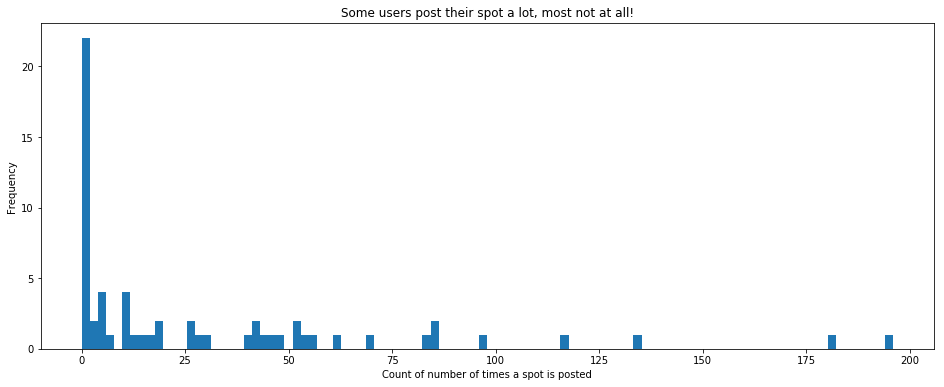

In [53]:
abt_histo = abt_by_spot['Booked'].hist(grid=False, bins=100, figsize=(16,6))
abt_histo.set_title('Some users post their spot a lot, most not at all!')
abt_histo.set_xlabel('Count of number of times a spot is posted')
abt_histo.set_ylabel('Frequency')